# Eigen Face


Facial recognition using the eigen face algorithm adapted from Turk and Pentland's Eigenfaces for Face Detection/Recognition.

### Resources
There are great resources for learning about the eigenface algorithm my favourites are:
- [Math ∩ Programming](https://jeremykun.com/2011/07/27/eigenfaces/) -- this is one of my favourite blogs.
- [Wikipedia](https://en.wikipedia.org/wiki/Eigenface)
- [The original article](http://www.face-rec.org/algorithms/PCA/jcn.pdf)

Steps: 
- Load image dataset
- Convert image dataset to the principle component basis
- Find similarity between faces

Eigenface was one of the first methods used for the task of facial recognition. There are currently better methods for facial recognition such as convolutional neural networks; however, the mathematics the eigenface algorithm employs (namely principle component analysis) is a fundamental tool for finding meaningful information in high dimensional data. 

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import scipy
import scipy.spatial.distance as dist
%matplotlib inline

In [2]:
# Set your own path to the image datasets
training_path = '/home/banner/Documents/ANU/cv/CLAB4/yalefaces/trainingset'

test_path = '~/Document/ANU/cv/CLAB4/yalefacles/testset'

## Load Data 

A two dimensional (or three dimensional for color images) matrix is a natural way of repersenting an image. We can map each pixel directly to a cell in the matrix. This structure is less effective when using multiple images. Since we don't care about the structure of pixels within an image so much as the value of a single pixel across multiple images we can convert each image to a (width * height x 1) length column vector and then store an entire set of images in a two dimensional matrix. 

Let's give some types we are going to be using names. This will help clear up confusion as we go on

let n: number of pictures in our database

let w: the width of each image

let h: the height of each image

let m: $w \times h$

So now we can say we are converting our database of images to a $\mathbb{R}^{m \times n}$ matrix

In [3]:
images_large = []
img_paths = os.listdir(training_path)

for file in img_paths:
    img = cv2.imread(os.path.join(training_path, file))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    reshaped = np.array(gray).flatten()
    images_large.append(reshaped)
    
images = np.transpose(images_large)

In [4]:
images.shape # Should be (m x n)

(45045, 135)

## Center images on origin

Now we want to center our data such that the mean for any pixel across all of the images in our dataset is zero. This simply involves finding the mean face and subtracting it from each face in our database. 

In [5]:
mean = np.mean(images, axis=1)

And just for fun let us have a look at our mean image. Since our mean is a column vector let's first build a function to map column vectors into images this will frequently come in handy. 

In [6]:
def vec2img(vec):
    return np.reshape(vec, (231, 195)).astype(int)

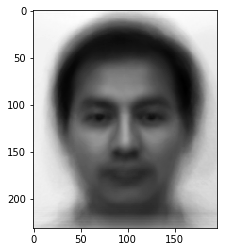

In [7]:
plt.imshow(vec2img(mean),cmap='gray')
plt.show()

Now we can subtract are mean face from the rest of the images in dataset. 'A' is my favourite name for a matrix so I'll call the resulting matrix that. And since our subtraction will not change the type (shape) of our matrix A will still be of type $\mathbb{R}^{m \times n}$

In [8]:
A = (images.transpose() - mean).transpose()

Just for kicks and giggles let's have a look at what some of our images look like after the mean is subtracted from them. 

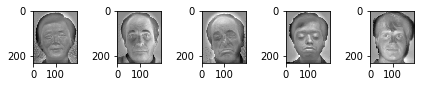

In [9]:
for i in range(0, 5):
    img = A[:, i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(vec2img(img),cmap='gray')
    
plt.tight_layout(h_pad=1.0)
plt.show()

## Finding a new basis

So far everything has been pretty straight forward. It's time to start using some linear algebra. Basically, there are few ways to proceed from here and the way you would naturally proceed does not work but there is a little trick you can use to sort everything out. Let's explore the natural progression first and find out why it will not work. 

### The problem
First let's just make sure we know what problem we our trying to solve. We have a matrix of images that is in $\mathbb{R}^{m \times n}$ where m is really big. We would like to be able to represent this information in a lower dimension ($\mathbb{R}^{small \times n}$). This is the use-case for principle component analysis (PCA) so let us explore what would happen if we went down that route

### Using naïve PCA
Okay first we want to find the covariance matrix. The covariance matrix is a notation for displaying the covariance between every 2-set of pixels in all the images. Intuitively, this is helpful because if say some set of n pixels are highly correlated we only need to store one value for all of the pixels (with minimum information loss). This is exactly what PCA aims to do. However, we have already run across a bit of a problem. In order to relate every 2-set of pixels we would need a matrix of type $\mathbb{R}^{m \times m}$ (that's roughly a gigabyte). So that won't work let's have a look at another method. 

### Another method of PCA
Let's just do the mathematics and everything will become pretty clear.
Our covariance matrix is defined as $A^{\intercal}A$ that's the matrix from the last section that got to be quite big. We want to find the eigenvectors for the covariance matrix. Recall that an eigenvector eigenvalue pair $(v, \lambda)$ for matrix X must satisfy $X \times v = \lambda \times v$. So all of the eigenvectors eigenvalue pairs for our covariance matrix will satisfy $$A^{\intercal}A \times v = \lambda \times v$$
So notice if we multiply on the left by A and reduce we get $$ (AA^{\intercal})A\times v = \lambda A v$$
This is awesome because $AA^{\intercal}$ is much easier to deal with because it is of type $\mathbb{R}^{n \times n}$ and A is of type $\mathbb{R}^{m \times n}$ so we now have our problem in dimensionality that we can work with. Now let's find a new basis for our dataset we'll call the basis vectors eigen faces because that's the standard. 

In [10]:
eigen_values, eigen_vectors = np.linalg.eig(np.matmul(A.transpose(), A))
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

Now we need to remember to multiply back by A (on the left) to get the eigen vectors of $A^{\intercal}A$

In [11]:
eigen_faces = np.matmul(A, eigen_vectors)

So our eigen faces now represent a new coordinate system for storing and our face images. Let's have a look at a couple of the eigen faces. 

/home/banner/.virtualenvs/cv/lib/python3.5/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


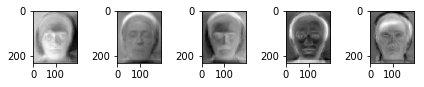

In [12]:
for i in range(0, 5):
    img = eigen_faces[:, i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(vec2img(img),cmap='gray')
    
plt.tight_layout(h_pad=1.0)
plt.show()

Let's just work with fifteen of the most descriptive eigen faces. Since we already sorted our eigen vectors by largest corresponding eigen values our fifteen most descriptive eigen faces will simply be the first fifteen eigen faces.

In [13]:
eigen_faces_15 = eigen_faces[:, 0:15]

In [14]:
eigen_faces_15.shape # Nice space to work in. 

(45045, 15)

## Image recognition

Let's first convert all of our dataset into our new eigen space. 

In [15]:
small_dataset = np.matmul(A.transpose(), eigen_faces_15)

In [16]:
small_dataset.shape

(135, 15)

Now each of our faces is represented in just 15 bytes of information (down from 45045). That's great. Let's try to recognize a face by
- taking a face from our data set
- converting it into the 15 dimensional basis for our new coordinate system
- computing the similarity between it and other faces
- displaying the five most similar faces

In [17]:
random_index = random.randint(0, images.shape[1])
random_face = images[:, random_index]
normalized_random_face = random_face - mean

random_eigen_representation = np.reshape(np.matmul(normalized_random_face.transpose(), eigen_faces_15), (1, -1))

dists = dist.cdist(small_dataset, random_eigen_representation, metric="euclidean")[:, 0]
indices = np.argsort(dists)[0: 5]

/home/banner/.virtualenvs/cv/lib/python3.5/site-packages/numpy/core/numeric.py:620: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order='C', ndmin=1)


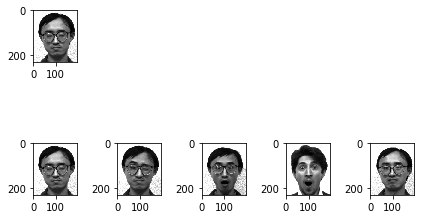

In [18]:
plt.subplot(2, 5, 1)
plt.imshow(vec2img(random_face), cmap='gray')

for i, index in enumerate(indices):
    img = images[:, index]
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(vec2img(img),cmap='gray')
    
plt.tight_layout(h_pad=1.0)
plt.show()

As shown we generally able recognize the face based only on our 15 dimension representation of the face. To increase accuracy more eigen values could be used. To decrease time and space of storing the dataset fewer eigen values could be used. Eigenfaces are a really concise way of representing a face, but they are not a golden bullet. We will lose some information when converting to an eigenface. To illustrate that let's convert a face we have compressed back into an image. 

## Converting back into an image

This is pretty straight forward we just need to do the reverse operation of getting an image into the eigen space.

In [28]:
compressed_face = small_dataset[random_index]
decompressed_face = np.matmul(compressed_face, np.linalg.pinv(eigen_faces_15)).transpose() + mean

/home/banner/.virtualenvs/cv/lib/python3.5/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


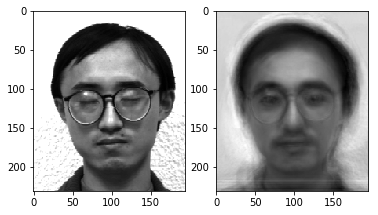

In [29]:
plt.subplot(1, 2, 1)
plt.imshow(vec2img(random_face), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(vec2img(decompressed_face), cmap='gray')

This seems pretty good. Let's recall, the image on the right was constructed from our mean face, the basis for our eigen faces, and the image representation was just 15 bytes. 

In [31]:
compressed_face.shape

(15,)

This will signficantly reduce the size of our image set while retaining enough information for us to recognize the individual and enough information for a simple similarity algorithm to identify the person. 

## Final thoughs

The eigen face algorithm is pretty out dated. It is not tolerant to image scale or minor variations in head rotation. You'll notice that the image set we used had all of the faces with very little variance in rotation or translation. In the real world it is probably unlikely to be faced with such a perfect training set. Convolution neural nets (CNNs) are more robust to these kind of issues. 